## Activity 5 – Develop a DCGAN for Grayscale Handwritten Digits
In this activity, we will:
* MNIST  Handwritten Digit Dataset
* Define and Train the Discriminator Model
* Define and Use the Generator Model
* Training the Generator Model
* Evaluating the Performance of the GAN
* Complete Example of Training the GAN
* Using the Final Generator Model



### Mount Google Drive

---



Mount your Google Drive on your runtime using an authorization code.

Follow the instruction on the screen to authorise Colab accessing your drive. On your Google Drive, you can access you files prepend with “/content/drive/MyDrive/”

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Replace the path below with the folder location of your choice.

In [2]:
output_folder = '/content/drive/MyDrive/Crafting/DLP/Day 2'

### MNIST  Handwritten Digit Dataset

The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.   It is a dataset of 70,000 small square 28 × 28 pixel grayscale images of handwritten single digits between 0 and 9.

Keras provides access to the MNIST dataset via the **mnist.load_dataset()** function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset. The code snippet below loads the dataset and summarizes the shape of the loaded dataset. 


In [3]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
from matplotlib import pyplot

In [4]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# summarize the shape of the dataset
print("Train", trainX.shape, trainy.shape)
print("Test", testX.shape, testy.shape)

11493376/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


Running the above loads the dataset and prints the shape of the input and output components of the train and test splits of images as shown above.

There are 60K examples in the training set and 10K in the test set and that each image is a square of 28 by 28 pixels.  

The images are grayscale with a black background (0 pixel value) and the handwritten digits in white (pixel values near 255).  The images are easier to review when we reverse the colours and plot the background as white and the handwritten digits in black.  The code below plots the first 25 images from the training dataset in a 5 by 5 square. 

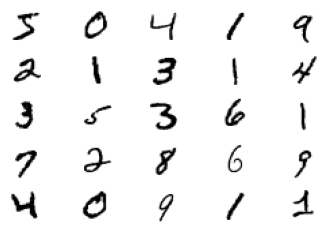

In [5]:
# plot images from the training dataset
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis
	pyplot.axis("off")
	# plot raw pixel data 
	pyplot.imshow(trainX[i], cmap="gray_r")
 
pyplot.show()

Running the above creates a plot of 25 images from the MNIST training dataset, arranged in a 5×5 square as shown below.

We will use the images in the training dataset as the basis for training a Generative Adversarial Network. Specifically, the generator model will learn how to generate new plausible handwritten digits between 0 and 9, using a discriminator that will try to distinguish between real images from the MNIST training dataset and new images output by the generator model. This is a relatively simple problem that does not require a sophisticated generator or discriminator model, although it does require the generation of a grayscale output image.

### Define and Train the Discriminator Model

---



The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake. This is a binary classification problem:.
-	**Inputs**: Image with one channel and 28 × 28 pixels in size..
-	**Outputs**: Binary classification, likelihood the sample is real (or fake). 


We define the discriminator as:

1. two convolutional layers with 64 filters each,
2. a small kernel size of 3, and
3. larger than normal stride of 2. 
4. the model has no pooling layers and 
5. a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake


The model is trained to minimize the binary cross-entropy loss function, appropriate for binary classification. We will use some best practices in defining the discriminator model, such as the use of LeakyReLU instead of ReLU, using Dropout, and using the Adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5. The function **define_discriminator()** below defines the discriminator model and parametrizes the size of the input image. 

In [6]:
# example of defining the discriminator model
# example of training the discriminator model on real and random mnist images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding="same", input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation="sigmoid"))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
  return model

We can go define the discriminator and plot the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

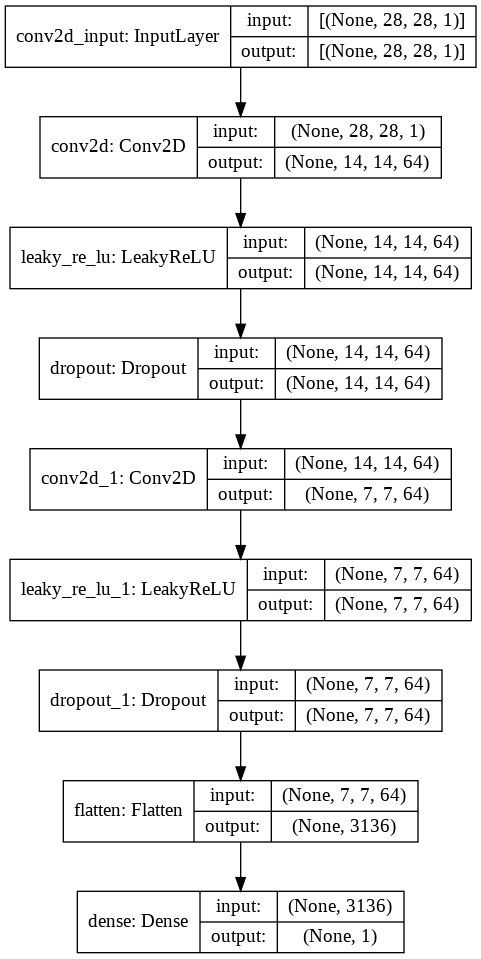

In [7]:
# define model
model = define_discriminator()

# summarize the model
model.summary()

# plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

**Note**: We can see that the aggressive 2 × 2 stride acts to downsample the input image, first from 28 × 28 to 14 × 14, then to 7 × 7, before the model makes an output prediction. This pattern is by design as we do not use pooling layers and use the large stride as to achieve a similar downsampling effect. We will see a similar pattern, but in reverse, in the generator model in the next section. 

A plot of the model is also created and we can see that the model expects two inputs and will predict a single output. 

We could start training this model now with real examples with a class label of one, and randomly generated samples with a class label of zero. The development of these elements will be useful later, and it helps to see that the discriminator is just a normal neural network model for binary classification. 


We need a function to load and prepare the dataset of real images. We will use the **mnist.load data()** function to load the MNIST dataset and just use the input part of the training dataset as the real images. 


```
   # load mnist dataset
  (trainX, _), (_, _) = load_data()
```


The images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of images as input, where each image has one or more channels, we must update the images to have an additional dimension for the grayscale channel. We can do this using the expand_dims() NumPy function and specify the final dimension for the channels-last image format. 


```
  # expand to 3d, e.g. add channels dimension
  X = expand_dims(trainX, axis=-1)
```


Finally, we must scale the pixel values from the range of unsigned integers in [0,255] to the normalized range of [0,1]. It is best practice to use the range [-1,1], but in this case the range [0,1] works just fine. 

```
  # convert from unsigned ints to floats
  X = X.astype("float32")
  # scale from [0,255] to [0,1]
  X = X / 255.0
```

The load_real_samples() function below implements this. 

In [8]:
# load and prepare mnist training images
def load_real_samples():
  # load mnist dataset
  (trainX, _), (_, _) = load_data()
  # expand to 3d, e.g. add channels dimension
  X = expand_dims(trainX, axis=-1)
  # convert from unsigned ints to floats
  X = X.astype("float32")
  # scale from [0,255] to [0,1]
  X = X / 255.0
  return X

h)	The model will be updated in batches, specifically with a collection of real samples and a collection of generated samples. On training, an epoch is defined as one pass through the entire training dataset. We could systematically enumerate all samples in the training dataset, and that is a good approach, but good training via stochastic gradient descent requires that the training dataset be shuffled prior to each epoch. A simpler approach is to select random samples of images from the training dataset. The **generate_real_samples()** function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of 1, to indicate real images. 

In [9]:
# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate "real" class labels (1)
  y = ones((n_samples, 1))
  return X, y

Now, we need a source of fake images. We don’t have a generator model yet, so instead, we can generate images comprised of random pixel values, specifically random pixel values in the range [0,1] like our scaled real images. The **generate_fake_samples() **function below implements this behaviour and generates images of random pixel values and their associated class label of 0, for fake. 

In [10]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
  # generate uniform random numbers in [0,1]
  X = rand(28 * 28 * n_samples)
  # reshape into a batch of grayscale images
  X = X.reshape((n_samples, 28, 28, 1))
  # generate "fake" class labels (0)
  y = zeros((n_samples, 1))
  return X, y

Finally, we need to train the discriminator model. This involves repeatedly retrieving samples of real images and samples of generated images and updating the model for a fixed number of iterations. We will ignore the idea of epochs for now (e.g. complete passes through the training dataset) and fit the discriminator model for a fixed number of batches. The model will learn to discriminate between real and fake (randomly generated) images rapidly, therefore, not many batches will be required before it learns to discriminate perfectly. 

The **train_discriminator()** function implements this, using a batch size of 256 images where 128 are real and 128 are fake each iteration. We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the model on each sample prior to the update. This gives insight into how the discriminator model is performing over time. 


In [11]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_iter):
    # get randomly selected "real" samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)

    # generate "fake" examples
    X_fake, y_fake = generate_fake_samples(half_batch)
    # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    
    # summarize performance
    print(" > %d real=%.0f%% fake=%.0f%%" % (i + 1, real_acc * 100, fake_acc * 100))

We can define and train the discriminator as shown below

In [12]:
# define the discriminator model
model = define_discriminator()

# load image data
dataset = load_real_samples()

# fit the model
train_discriminator(model, dataset)

 > 1 real=34% fake=59%
 > 2 real=38% fake=74%
 > 3 real=41% fake=88%
 > 4 real=41% fake=95%
 > 5 real=34% fake=100%
 > 6 real=41% fake=100%
 > 7 real=39% fake=100%
 > 8 real=43% fake=100%
 > 9 real=56% fake=100%
 > 10 real=47% fake=100%
 > 11 real=45% fake=100%
 > 12 real=54% fake=100%
 > 13 real=51% fake=100%
 > 14 real=53% fake=100%
 > 15 real=63% fake=100%
 > 16 real=66% fake=100%
 > 17 real=77% fake=100%
 > 18 real=75% fake=100%
 > 19 real=77% fake=100%
 > 20 real=80% fake=100%
 > 21 real=80% fake=100%
 > 22 real=78% fake=100%
 > 23 real=89% fake=100%
 > 24 real=91% fake=100%
 > 25 real=87% fake=100%
 > 26 real=94% fake=100%
 > 27 real=92% fake=100%
 > 28 real=100% fake=100%
 > 29 real=96% fake=100%
 > 30 real=98% fake=100%
 > 31 real=97% fake=100%
 > 32 real=98% fake=100%
 > 33 real=99% fake=100%
 > 34 real=100% fake=100%
 > 35 real=98% fake=100%
 > 36 real=99% fake=100%
 > 37 real=100% fake=100%
 > 38 real=99% fake=100%
 > 39 real=99% fake=100%
 > 40 real=100% fake=100%
 > 41 rea

The discriminator model learns to tell the difference between real and generated MNIST images very quickly, in about 30 iterations. 

### Define and Use the Generator Model

The generator model is responsible for creating new, fake but plausible images of handwritten digits. It does this by taking a point from the latent space as input and outputting a square grayscale image. The latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions.  It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points. At the end of training, the latent vector space represents a compressed representation of the output space, MNIST images, that only the generator knows how to turn into plausible MNIST images. 
-	**Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers. 
-	**Outputs**: Two-dimensional square grayscale image of 28 × 28 pixels with pixel values in [0,1]. 


Note:  
1. We don’t have to use a 100 element vector as input; it is a round number and widely used, but expect that 10, 50, or 500 would work just as well.  
2. Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 28 × 28 or 784 values. There are a number of ways to achieve this but there is one approach that has proven effective at deep convolutional generative adversarial networks. It involves two main elements. The first is a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 14 × 14 or 196 nodes, and an image one quarter the size (one eighth the area) would be 7 × 7 or 49 nodes.


We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate. **Therefore, the first hidden layer, the Dense layer needs enough nodes for multiple low-resolution versions of our output image, such as 128**. 

```
  model.add(Dense(n_nodes, input_dim=100))
```



The activations from these nodes can then be reshaped into something image-like to pass into a convolutional layer, such as 128 different 7 × 7 feature maps.

```
  model.add(Reshape((7, 7, 128)))
```



d)	The next major architectural innovation involves upsampling the low-resolution image to a higher resolution version of the image. There are two common ways to do this upsampling process, sometimes called deconvolution. One way is to use an UpSampling2D layer (like a reverse pooling layer) followed by a normal Conv2D layer. The other and perhaps more modern way is to combine these two operations into a single layer, called a Conv2DTranspose. We will use this latter approach for our generator. 
The **Conv2DTranspose** layer can be configured with a stride of (2 × 2) that will quadruple the area of the input feature maps (double their width and height dimensions). It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to avoid a checkerboard pattern that can be observed when upsampling. 

```
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")) 
```




This can be repeated to arrive at our 28×28 output image.  we will use the LeakyReLU activation with a default slope of 0.2, reported as a best practice when training GAN models.   The output layer of the model is a Conv2D with one filter and a kernel size of 7 × 7 and ‘same’ padding, designed to create a single feature map and preserve its dimensions at 28 × 28 pixels. A sigmoid activation is used to ensure output values are in the desired range of [0,1]. The define generator() function below implements this and defines the generator model. The generator model is not compiled and does not specify a loss function or optimization algorithm. This is because the generator is not trained directly 

The following code define the generator model and summarize it.

In [13]:
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from numpy.random import randn

# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")) 
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")) 
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7, 7), activation="sigmoid", padding ="same")) 
  return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 128)      

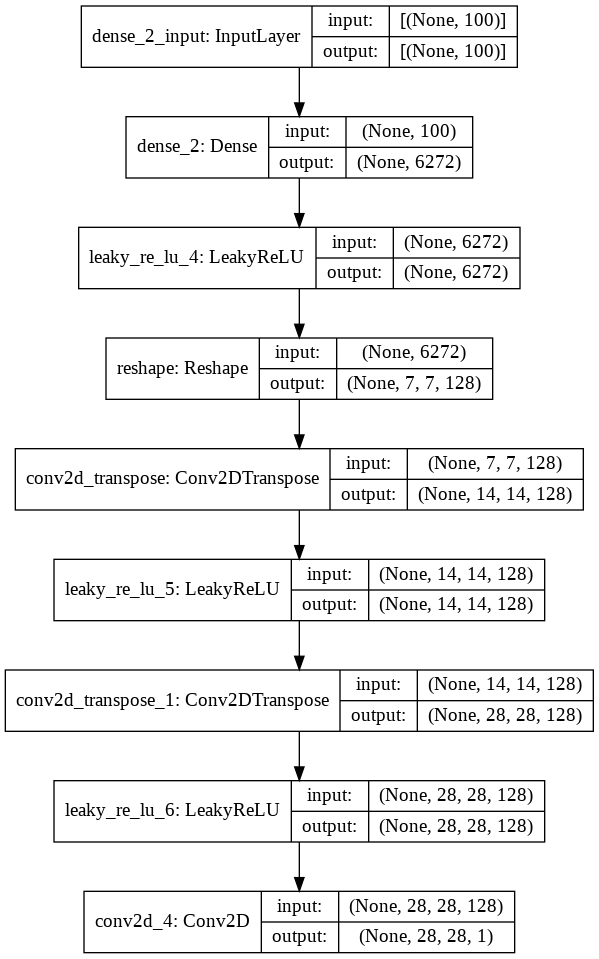

In [14]:
# define the size of the latent space
latent_dim = 100

# define the generator model
model = define_generator(latent_dim)

# summarize the model
model.summary()

# plot the model
plot_model(model, show_shapes = True, show_layer_names = True)

We can see that, as designed, the first hidden layer has 6,272 parameters or 128 × 7 × 7, the activations of which are reshaped into 128 7 × 7 feature maps. The feature maps are then upscaled via the two Conv2DTranspose layers to the desired output shape of 28 × 28, until the output layer, where a single activation map is output. 

This model cannot do much at the moment. Nevertheless, we can demonstrate how to use it to generate samples. This is a helpful demonstration to understand the generator as just another model, and some of these elements will be useful later. 

The first step is to draw new points from the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian. The array of random numbers can then be reshaped into samples, that is n rows with 100 elements per row. The **generate_latent_points()** function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model. 

In [15]:
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

Next, we can use the generated points as input to the generator model to generate new samples, then plot the samples. We can update the **generate_fake_samples()** function from the previous section to take the generator model as an argument and use it to generate the desired number of samples by first calling the generate_latent_points() function to generate the required number of points in latent space as input to the model. The updated **generate_fake_samples()** function is listed below and returns both the generated samples and the associated class labels. 

In [16]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create "fake" class labels (0)
  y = zeros((n_samples, 1))
  return X, y

Let us generates 25 examples of fake MNIST images and visualizes them on a single plot of 5 by 5 images. As the model is not trained, the generated images are completely random pixel values in [0, 1]. 

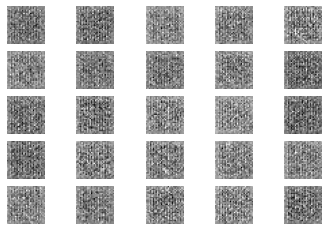

In [17]:
# size of the latent space
latent_dim = 100

# define the discriminator model
model = define_generator(latent_dim)

# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)

# plot the generated samples
for i in range(n_samples):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis labels
  pyplot.axis("off")
  # plot single image
  pyplot.imshow(X[i, :, :, 0], cmap="gray_r")

# show the figure
pyplot.show()

### Training the Generator Model

---



The weights in the generator model are updated based on the performance of the discriminator model. When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less. This defines the zero-sum or adversarial relationship between these two models. There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that combines the generator and discriminator models.

A new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator. 

To be clear, we are not talking about a new third model, just a new logical model that uses the already-defined layers and weights from the standalone generator and discriminator models. Only the discriminator is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner.


The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they cannot be updated and overtrained on fake examples.  When training the generator via this logical GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class = 1). 

-	**Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers. 
-	**Outputs**: Binary classification, likelihood the sample is real (or fake).. 



The **define_gan()** function below takes as arguments the already-defined generator and discriminator models and creates the new logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model. The GAN model then uses the same binary cross-entropy loss function as the discriminator and the efficient Adam version of stochastic gradient with the learning rate of 0.0002 and momentum 0.5, recommended when training deep convolutional GANs. .

In [18]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

Note:  Making the discriminator not trainable is a clever trick in the Keras API. The trainable property impacts the model when it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to **train_on_batch()**. The discriminator model was marked as not trainable, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to **train_on_batch()**.

Let us creates a summary of the composite model.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


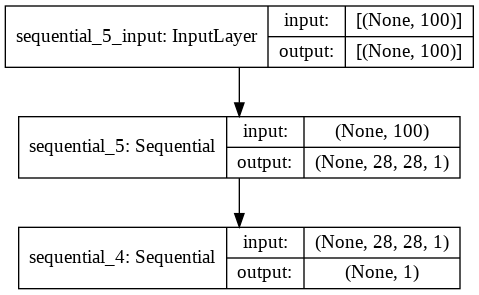

In [19]:
# size of the latent space
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# summarize gan model
gan_model.summary()

# plot gan model
plot_model(gan_model, show_shapes=True, show_layer_names=True)

We can see that the model expects MNIST images as input and predicts a single value as output. 

Training the composite model involves generating a batch-worth of points in the latent space via the **generate_latent_points()** function in the previous section, and class = 1 labels and calling the **train_on_batch()** function. The **train_gan()** function below demonstrates this, although it is pretty simple as only the generator will be updated each epoch, leaving the discriminator with default model weights.

```
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
  # manually enumerate epochs
  for i in range(n_epochs):
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator’s error 
    gan_model.train_on_batch(x_gan, y_gan)   
```



Instead, what is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model. This requires combining elements from the **train_discriminator()** function defined in the discriminator section and the **train_gan()** function defined above. It also requires that we enumerate over both epochs and batches within in an epoch. The complete train function for updating the discriminator model and the generator (via the composite model) is listed below. 

Note: 
1. the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 60K samples and a batch size of 256, so with rounding down, there are 60000/256 or 234 batches per epoch.
2. The discriminator model is updated once per batch by combining one half a batch (128)  of fake and real (128) examples into a single batch via the vstack() NumPy function. You could update the discriminator with each half batch separately (recommended for more complex datasets) but combining the samples into a single batch will be faster over a long run, especially when training on GPU hardware.
3. Finally, we report the loss for each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate. Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch on this dataset. The generator loss is less critical and may hover between 0.5 and 2 or higher on this dataset. A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process. 



```
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):

      # get randomly selected "real" samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate "fake" examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      
      # summarize loss on this batch
      print(">%d, %d/%d, d=%.3f, g=%.3f" % (i + 1, j + 1, bat_per_epo, d_loss, g_loss))
```



***We will not create the train() funtion yet as we will be make modification later now.***

### Evaluating the Performance of the GAN

---



Generally, **there are no objective ways to evaluate the performance of a GAN model.  We cannot calculate this objective error score for generated images.**

It might be possible in the case of MNIST images because the images are so well constrained, but in general, it is not possible (yet).  Instead, images must be subjectively evaluated for quality by a human operator. This means that we cannot know when to stop training without looking at examples of generated images. In turn, the adversarial nature of the training process means that the generator is changing after every batch, meaning that once good enough images can be generated, the subjective quality of the images may then begin to vary, improve, or even degrade with subsequent updates.  There are three ways to handle this complex training situation. 
-	Periodically evaluate the classification accuracy of the discriminator on real and fake images. 
-	Periodically generate many images and save them to file for subjective review. 
-	Periodically save the generator model. 

All three of these actions can be performed at the same time for a given training epoch, such as every five or 10 training epochs. The result will be a saved generator model for which we have a way of subjectively assessing the quality of its output and objectively knowing how well the discriminator was fooled at the time the model was saved. Training the GAN over many epochs, such as hundreds or thousands of epochs, will result in many snapshots of the model that can be inspected and from which specific outputs and models can be cherry-picked for later use. 

First, we can define a function called **summarize_performance()** that will summarize the performance of the discriminator model. It does this by retrieving a sample of real MNIST images, as well as generating the same number of fake MNIST images with the generator model, then evaluating the classification accuracy of the discriminator model on each sample and reporting these scores.


```
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(">Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real*100, acc_fake*100)) 

```



This function can be called from the **train()** function based on the current epoch number, such as every 10 epochs. 

```
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
  ...
  # evaluate the model performance, sometimes
  if (i+1) % 10 == 0:
    summarize_performance(i, g_model, d_model, dataset, latent_dim)

```



Next, we can update the **summarize_performance()** function to both save the model and to create and save a plot generated examples. The generator model can be saved by calling the save() function on the generator model and providing a unique filename based on the training epoch number. 

```
... 
# save the generator model tile file
filename = “generator_model_%03d.h5” % (epoch + 1) 
g_model.save(filename) 

```




We can develop a function to create a plot of the generated samples. As we are evaluating the discriminator on 100 generated MNIST images, we can plot all 100 images as a 10 by 10 grid. The **save_plot()** function below implements this, again saving the resulting plot with a unique filename based on the epoch number

In [20]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis("off")
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap="gray_r")

  # save plot to file
  filename = output_folder + "/generated_MNIST_plot_e%03d.png" % (epoch + 1)
  pyplot.savefig(filename)
  pyplot.close()

The updated summarize performance() function with these additions is listed below. 

In [21]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(" > Accuracy real: %.0f%%, fake:%.0f%%" % (acc_real * 100, acc_fake * 100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = output_folder + "/generator_MNIST_model_%03d.h5" % (epoch + 1)
  g_model.save(filename)

The updated train() function is provided below

In [22]:
from numpy import vstack

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):

      # get randomly selected "real" samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate "fake" examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator"s error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      
      # summarize loss on this batch
      print(">%d, %d/%d, d=%.3f, g=%.3f" % (i + 1, j + 1, bat_per_epo, d_loss, g_loss))
    # evaluate the model performance, sometimes
    if (i + 1) % 20 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

We can now train the GAN

In [23]:
%%time 

# size of the latent space
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# load image data
dataset = load_real_samples()

# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>79, 153/234, d=0.689, g=0.700
>79, 154/234, d=0.685, g=0.711
>79, 155/234, d=0.690, g=0.698
>79, 156/234, d=0.694, g=0.709
>79, 157/234, d=0.688, g=0.716
>79, 158/234, d=0.695, g=0.708
>79, 159/234, d=0.690, g=0.711
>79, 160/234, d=0.686, g=0.706
>79, 161/234, d=0.695, g=0.702
>79, 162/234, d=0.693, g=0.713
>79, 163/234, d=0.693, g=0.717
>79, 164/234, d=0.687, g=0.696
>79, 165/234, d=0.698, g=0.687
>79, 166/234, d=0.692, g=0.674
>79, 167/234, d=0.689, g=0.693
>79, 168/234, d=0.689, g=0.719
>79, 169/234, d=0.691, g=0.711
>79, 170/234, d=0.690, g=0.692
>79, 171/234, d=0.683, g=0.718
>79, 172/234, d=0.696, g=0.706
>79, 173/234, d=0.694, g=0.728
>79, 174/234, d=0.691, g=0.715
>79, 175/234, d=0.687, g=0.695
>79, 176/234, d=0.690, g=0.684
>79, 177/234, d=0.696, g=0.688
>79, 178/234, d=0.698, g=0.681
>79, 179/234, d=0.691, g=0.707
>79, 180/234, d=0.691, g=0.709
>79, 181/234, d=0.696, g=0.703
>79, 182/234, d=0.686, g=0.698
>79, 183/234, d=0.6

Note: Running the example may take many hours to run on CPU hardware. I recommend running the code on GPU hardware if possible. 

The chosen configuration results in the stable training of both the generative and discriminative model. The model performance is reported every batch, including the loss of both the discriminative (d) and generative (g) models. 

Your specific results may vary given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance. 

In this case, the loss remains stable over the course of training. 

The generator is evaluated every 10 epochs, resulting in 10 evaluations, 10 plots of generated images, and 10 saved models. In this case, we can see that the accuracy fluctuates over training. When viewing the discriminator model’s accuracy score in concert with generated images, we can see that the accuracy on fake examples does not correlate well with the subjective quality of images, but the accuracy for real examples may. It is crude and possibly unreliable metric of GAN performance, along with loss.

More training, beyond some point, does not mean better quality generated images. In this case, the results after 10 epochs are low quality, although we can see that the generator has learned to generate centred figures in white on a black background 

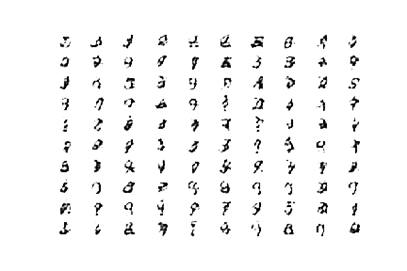

After 20 or 30 more epochs, the model begins to generate very plausible MNIST figures, suggesting that 100 epochs are probably not required for the chosen model configurations. 

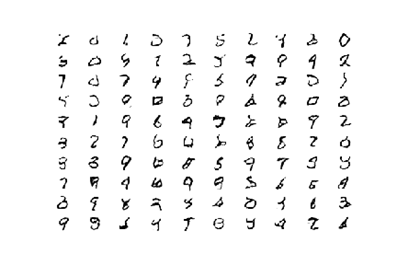

The generated images after 100 epochs are not greatly different, but we can detect less blocky-ness in the curves. 

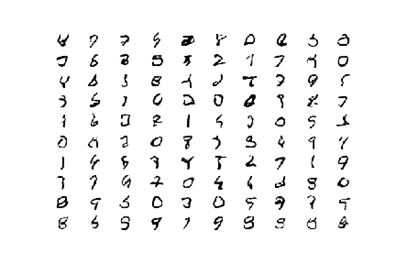

### Using the Final Generator Model

Once a final generator model is selected, it can be used in a standalone manner for your application. This involves first loading the model from file, then using it to generate images. The generation of each image requires a point in the latent space as input. The complete example of loading the saved model and generating images is listed below. In this case, we will use the model saved after 100 training epochs, but the model saved after 40 or 50 epochs would work just as well. 

In [24]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

In [25]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [26]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis("off")
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap="gray_r")
  pyplot.show()

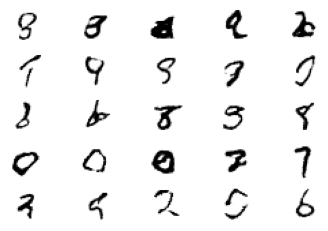

In [27]:
# load model
filename = output_folder + "/generator_MNIST_model_100.h5"
model = load_model(filename)

# generate images
latent_points = generate_latent_points(100, 25) # generate images
X = model.predict(latent_points)

# plot the result
save_plot(X, 5)

first loads the model, samples 25 random points in the latent space, generates 25 images, then plots the results as a single image. 

The latent space now defines a compressed representation of MNIST handwritten digits. You can experiment with generating different points in this space and see what types of numbers they generate. The example below generates a single handwritten digit using a vector of all 0.0 values

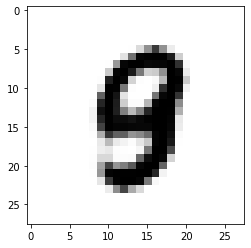

In [28]:
from numpy import asarray
# all 0s
vector = asarray([[0.0 for _ in range(100)]]) 
# generate image
X = model.predict(vector)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap="gray_r")
pyplot.show()


In this case, a vector of all zeros results in a handwritten 9. You can then try navigating the space and see if you can generate a range of similar, but different handwritten digits. 